# Full notebook.

## Team Data and Coffee ☕

This is the full notebook for the Pokémon Battle Winner Prediction Challenge 2025.

In [97]:
import os
import sys
NB_DIR = os.path.abspath('')

# To make any library in nbdir import-able
if NB_DIR not in sys.path:
    sys.path.append(NB_DIR)

DATA_DIR = '../input'

In [127]:
import json, yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV 
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, SelectPercentile
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, \
    VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score

from prettytable import PrettyTable
from tqdm.notebook import tqdm

# --- Our own libraries ---

import feature_extraction as fe

# Reload automatically upon any change in feature_extraction.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
# Number of CPU cores to use in parallel by sklearn
# (where possible).
N_JOBS = 8

# Random state
RS = 42

In [100]:
# Load the training data from file into train_data list

def read_and_decode_data_file(file_path, remove_bogus_line=True):
    # Read and decode the file line by line
    print(f"Loading data from '{file_path}'...")
    train_data = []
    try:
        with open(file_path, 'r') as f:
            for line in f:
                # json.loads() parses one line (one JSON object) into a Python dictionary
                train_data.append(json.loads(line))

        if remove_bogus_line:
            train_data = [battle for battle in train_data if battle.get("battle_id") != 4877]
        
        print(f'Successfully loaded {len(train_data)} battles.')
        if remove_bogus_line:
            print('(Bogus battle_id=4877 deleted).')
        
        return train_data
    
    except FileNotFoundError:
        print(f"ERROR: Could not find the training file at '{train_file_path}'.")
        print('Please make sure you have added the competition data to this notebook.')
    
    except IOError:
        print(f"An error occurred while reading the file '{train_file_path}'.")


train_file_path = os.path.join(NB_DIR, DATA_DIR, 'train.jsonl')
train_data = read_and_decode_data_file(train_file_path)

Loading data from 'C:\Users\emazep\Dropbox\uni\2025-2026\FDS\FDS-Pokemon\working\../input\train.jsonl'...
Successfully loaded 9999 battles.
(Bogus battle_id=4877 deleted).


# Feature Engineering

At this point we have all the training data, decoded from JSON, in the `train_data` list (of nested structures), so it's time to work on the features, through techniques such as features selection and regularization. All the relevant functions are in the `feature_extraction` library (file `feature_extraction.py`).

In [183]:
# Feature extraction!
def extract_features(fun, data):
    print('Processing data...', end=' ')
    train_df = fun(data)
    print('Done!')
    print(train_df.shape)
    return train_df

feature_extraction_function = fe.build_features
train_df = extract_features(feature_extraction_function, train_data)

Processing data... 

Extracting features:   0%|          | 0/9999 [00:00<?, ?it/s]

Done!
(9999, 56)


# Models Training and Comparison

At this point we have all the selected features in to the `train_df` dataframe, so it's time to train the various models on them.

In [184]:
def define_X_y(data_df):
    # Define and return our features (X) and target (y)
    features = [col for col in data_df.columns if col not in ['battle_id', 'player_won']]
    
    # Any data scaling/regularization goes here
    #scaler = RobustScaler().fit(data_df[features])
    scaler = StandardScaler().fit(data_df[features])
    data_df_scaled = scaler.transform(data_df[features])
    
    # Chose whether to assign train_data the scaled version or the original one (train_df[features])
    X_data = data_df_scaled.copy()
    
    return X_data, data_df['player_won'] if 'player_won' in data_df else None

X_train_full, y_train_full = define_X_y(train_df)

In [209]:
# Split the data.
def split(X_train_full, y_train_full, test_size=0.2, shuffle=True):
    X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=test_size, shuffle=shuffle)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split(X_train_full, y_train_full, 0.2)

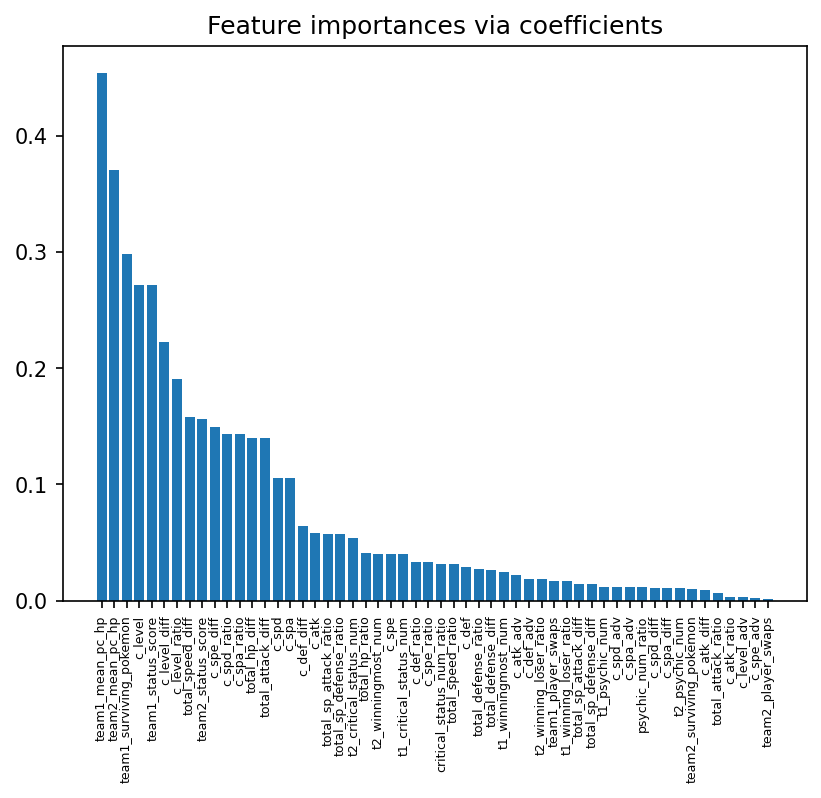

In [189]:
# Optional
# Univariate and "from model" features selection
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]

selector = LinearSVC().fit(X_train, y_train)
importance = np.abs(selector.coef_)

plt.rcParams['figure.dpi'] = 150
plot_x, plot_y = zip(*sorted(zip(features, importance[0]), key=lambda k: k[1], reverse=True))
plt.bar(plot_x, plot_y) # Sorted plot
#plt.bar(features, height=importance[0]) # Unsorted plot
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.xticks(fontsize=6)
plt.show()

In [ ]:
%%script true
# Optional
# Hyperparameter Tuning

# SVC
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
	'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
	'kernel': ('linear', 'rbf', 'poly')
} 
grid = GridSearchCV(SVC(random_state=RS), param_grid, refit=True, verbose=3) 
grid.fit(X_train, y_train)

In [ ]:
%%script true
# Optional
# Hyperparameter Tuning

# Ridge
param_grid = {
    'cv': [None, 2, 4, 5, 10]
} 
grid = GridSearchCV(RidgeClassifierCV(), param_grid, refit=True, verbose=3) 
grid.fit(X_train, y_train)

In [ ]:
%%script true
# Optional
# Hyperparameter Tuning

# LinearSVC
param_grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': [0.01, 0.1, 1, 10, 100],
    'tol': [0.00001, 0.0001, 0.001, 0.01]
} 
grid = GridSearchCV(LinearSVC(max_iter=50000, random_state=RS), param_grid, refit=True, verbose=3) 
grid.fit(X_train, y_train)

In [190]:
# (Near) Optimal Hypeparams for various models:
SCV_OPT_PARAM = {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Ridge_OPT_PARAM = {'cv': 5}
LinearSCV_OPT_PARAMC = {'C': 1, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.01}

In [211]:
# Models list (just add models with their parameters!)
models = [
    LogisticRegression(max_iter=10_000, random_state=RS),
    LogisticRegressionCV(max_iter=10_000, random_state=RS),
    SGDClassifier(max_iter=10_000, tol=1e-3, random_state=RS),
    GaussianNB(),
    DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5),
    GradientBoostingClassifier(random_state=RS, learning_rate=0.5),
    HistGradientBoostingClassifier(max_iter=10_000, random_state=RS),
    RidgeClassifierCV(**Ridge_OPT_PARAM),
    ExtraTreesClassifier(n_estimators=200, random_state=RS),
    LinearSVC(dual=False, random_state=RS),
    RandomForestClassifier(n_estimators=200, random_state=RS),
    KNeighborsClassifier(n_neighbors=100),
    GaussianProcessClassifier(random_state=RS),
    AdaBoostClassifier(random_state=RS),
    MLPClassifier(max_iter=10_000, random_state=RS),
    SVC(**SCV_OPT_PARAM, random_state=RS) # From Hypeparameter optimization
]

In [192]:
# Alternative reduced set of models
# (Running this cell overwrites the models collection set in the previous cell).
def set_models(max_iter=20_000):
    models = [
        LogisticRegressionCV(max_iter=max_iter, random_state=RS),
        LogisticRegression(max_iter=max_iter, random_state=RS),
        #HistGradientBoostingClassifier(max_iter=max_iter, random_state=RS),
        #GradientBoostingClassifier(random_state=RS),
        RidgeClassifierCV(**RIDGE_OPT_PARAM),
        #LinearSVC(dual=False, class_weight='balanced', tol=1e-6, max_iter=max_iter, random_state=RS)
        LinearSVC(dual=False, max_iter=max_iter, random_state=RS),
        SVC(**SCV_OPT_PARAM, random_state=RS) # From Hypeparameter optimization
    ]
    return models

models = set_models()

In [212]:
# Model testing with random split training

def test_models(X_train, y_train, X_test, y_test, models):
    models_result = []
    best_score = 0
    best_model = None
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_model = model
        models_result.append([model.__class__.__name__, score])
    
    print(best_model, '\t', best_score)
    return models_result


models_result = test_models(X_train, y_train, X_test, y_test, models)

C:\Users\emazep\miniforge3\envs\dev-3.12\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


LogisticRegressionCV(max_iter=10000, random_state=42) 	 0.86


In [213]:
# Print the model scores

def print_results(models_result):
    results_table = PrettyTable()
    results_table.field_names = ['Model Name', 'Accuracy']
    results_table.align['Model Name'] = 'r'
    results_table.align['Accuracy'] = 'l'
    results_table.add_rows(sorted([[result[0], round(result[1]*100, 3)] for result in models_result], key=lambda row: row[1]))
    print(results_table)

print_results(models_result)

+--------------------------------+----------+
|                     Model Name | Accuracy |
+--------------------------------+----------+
|                     GaussianNB | 72.75    |
|      GaussianProcessClassifier | 78.45    |
|         DecisionTreeClassifier | 81.05    |
|           KNeighborsClassifier | 81.05    |
|                  MLPClassifier | 81.3     |
|           ExtraTreesClassifier | 83.8     |
|         RandomForestClassifier | 83.8     |
|                  SGDClassifier | 84.05    |
|     GradientBoostingClassifier | 84.1     |
| HistGradientBoostingClassifier | 84.25    |
|             AdaBoostClassifier | 84.8     |
|              RidgeClassifierCV | 85.45    |
|                            SVC | 85.55    |
|                      LinearSVC | 85.65    |
|             LogisticRegression | 85.85    |
|           LogisticRegressionCV | 86.0     |
+--------------------------------+----------+


In [94]:
# Optional
# Model testing with cross-validation training - Alternative to the above!
models_result_cross = []

for model in models:
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    cv_results = cross_val_score(model, *define_X_y(train_df), cv=cv, n_jobs=N_JOBS)
    print(f'{model.__class__.__name__:<32} min: {cv_results.min():.3f}\tmean: {cv_results.mean():.3f}\tmax: {cv_results.max():.3f}')
    models_result_cross.append([model.__class__.__name__, cv_results.mean()])

LogisticRegressionCV             min: 0.845	mean: 0.853	max: 0.867
LogisticRegression               min: 0.844	mean: 0.852	max: 0.868
RidgeClassifierCV                min: 0.846	mean: 0.854	max: 0.865
LinearSVC                        min: 0.845	mean: 0.853	max: 0.865
SVC                              min: 0.846	mean: 0.854	max: 0.867


In [85]:
# ENSEMBLE - Set up estimators (models) to use
MAX_ITER = 50_000
estimators = [
    ('LR', LogisticRegression()),
    ('RC', RidgeClassifierCV(**RIDGE_OPT_PARAM)),
    ('LSVC', LinearSVC(max_iter=MAX_ITER, dual=False)),
    ('LRCV', LogisticRegressionCV(max_iter=MAX_ITER)),
    ('GBC', GradientBoostingClassifier()),
    ('SVC', SVC(**SCV_OPT_PARAM, random_state=RS))
]

In [22]:
# Optional
# ENSEMBLE - Stacking
es_clf = StackingClassifier(estimators=estimators, final_estimator=LinearSVC(), n_jobs=N_JOBS)
es_clf.fit(X_train, y_train)
es_clf.score(X_test, y_test)

0.846

In [95]:
# Optional
# ENSEMBLE - Bagging
eb_clf = BaggingClassifier(LinearSVC(**LinearSCV_OPT_PARAMC, max_iter=MAX_ITER, random_state=RS))
eb_clf.fit(X_train, y_train)
eb_clf.score(X_test, y_test)

0.844

In [181]:
# Optional
# Re-run the full pipeline at once!
# (Once the corresponding cells have been executed at least once).

train_df = extract_features(feature_extraction_function, train_data)
X_train_full, y_train_full = define_X_y(train_df)
X_train, X_test, y_train, y_test = split(X_train_full, y_train_full, 0.2, shuffle=True)
models = set_models(max_iter=20_000)
models_result = test_models(X_train, y_train, X_test, y_test, models)
print_results(models_result)

Processing data... 

Extracting features:   0%|          | 0/9999 [00:00<?, ?it/s]

Done!
(9999, 54)
SVC(C=0.1, gamma=0.01, kernel='linear', random_state=42) 	 0.8615
+----------------------+----------+
|           Model Name | Accuracy |
+----------------------+----------+
|    RidgeClassifierCV | 85.95    |
|            LinearSVC | 86.0     |
| LogisticRegressionCV | 86.05    |
|   LogisticRegression | 86.05    |
|                  SVC | 86.15    |
+----------------------+----------+


# Submission

Create the submission file with the best performing model (selected from the previous results).

In [ ]:
final_model = LinearSVC(**LinearSCV_OPT_PARAMC, max_iter=max_iter, random_state=RS)

test_file_path = os.path.join(NB_DIR, DATA_DIR, 'test.jsonl')
test_data = read_and_decode_data_file(test_file_path, remove_bogus_line=False)

In [ ]:
# Feature extraction from test data

exam_test_df = extract_features(feature_extraction_function, test_data)

In [ ]:
# Recreate the full X_train
train_df = extract_features(feature_extraction_function, train_data)
X_train_full, y_train_full = define_X_y(train_df)

In [ ]:
#Train the best model found so far on the full train_data
final_model.fit(X_train_full, y_train_full)
y_pred = final_model.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Print the score on the already seen testing set
# (a 100% score by a constrained model may be a sign of overfitting).
print(score)

In [ ]:
X_exam_test, _ = define_X_y(exam_test_df)

In [ ]:
print("Generating predictions on the test set...")
exam_test_predictions = final_model.predict(X_exam_test)
#y_test = final_model.predict(X_train)
#score = accuracy_score(y_test, train_df['player_won'])
#score
len(exam_test_predictions)

In [ ]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'battle_id': exam_test_df['battle_id'],
    'player_won': exam_test_predictions
})

In [ ]:
submission_file_path = os.path.join(NB_DIR, 'submission.csv')
submission_df.to_csv(submission_file_path, index=False)